In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

### Load data set 

Hansen et al (2013) state that the best performing neural networks used up to 1000 samples of randomized coulomb matrices. In this notebook, we will compare performance of randomized and eigenvector representations of the coulomb matrices. 

In [2]:
dataset_file = "../deepchem/datasets/gdb1k.sdf"
featurizer_eig = dc.feat.CoulombMatrixEig(23, remove_hydrogens=False)
featurizer_random = dc.feat.CoulombMatrix(max_atoms =23, remove_hydrogens=False, randomize=True, n_samples=10)

eig_loader = dc.data.SDFLoader(
      tasks=["atomization_energy"], smiles_field="smiles",
      featurizer=featurizer_eig,
      mol_field="mol")

random_loader = dc.data.SDFLoader(
      tasks=["atomization_energy"], smiles_field="smiles",
      featurizer=featurizer_random,
      mol_field="mol")

eig_dataset = eig_loader.featurize(dataset_file)
random_dataset = random_loader.featurize(dataset_file)




Loading raw samples now.
shard_size: 8192
Reading structures from ../deepchem/datasets/gdb1k.sdf.
Currently featurizing feature_type: CoulombMatrixEig
Featurizing sample 0
TIMING: featurizing shard 0 took 0.687 s
TIMING: dataset construction took 0.948 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
Reading structures from ../deepchem/datasets/gdb1k.sdf.
Currently featurizing feature_type: CoulombMatrix
Featurizing sample 0
TIMING: featurizing shard 0 took 3.038 s
TIMING: dataset construction took 3.436 s
Loading dataset from disk.


Hansen et al (2013) state that normalisation scaling of inputs is detrimental to model performance as the input dimensions are related. 
In this notebook, we will compare the performance of scaled and non-scaled inputs. 



In [33]:
# Split dataset
random_splitter = dc.splits.RandomSplitter()
stratified_splitter = dc.splits.RandomStratifiedSplitter()

datasets = {}

for name, data in zip(['eig', 'random'],[eig_dataset, random_dataset]):
    train_dataset, valid_dataset, test_dataset = random_splitter.train_valid_test_split(data)
    print("dataset sizes: \n")
    print("training: ", train_dataset.X.shape)
    print("validate: ", valid_dataset.X.shape)
    print("test: ", test_dataset.X.shape)
    datasets[name] = {'train': train_dataset, 'valid': valid_dataset, 'test': test_dataset}
    #train_dataset_random, valid_dataset, test_dataset = random_splitter.train_valid_test_split(random_dataset)


TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
dataset sizes: 

training:  (792, 23)
validate:  (99, 23)
test:  (100, 23)
TIMING: dataset construction took 0.308 s
Loading dataset from disk.
TIMING: dataset construction took 0.168 s
Loading dataset from disk.
TIMING: dataset construction took 0.169 s
Loading dataset from disk.
dataset sizes: 

training:  (792, 10, 23, 23)
validate:  (99, 10, 23, 23)
test:  (100, 10, 23, 23)


In [34]:

# Apply normalisation transformer
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]


# for name in ['eig', 'random']:
#     datasets[name]['normalised_train'] = dc.trans.NormalizationTransformer(transform_X=True, dataset=datasets[name]['train'])
# #    datasets[name]['normalised_train'] = dc.trans.NormalizationTransformer(transform_X=True, datasets[name]['train'])
    
for name in ['eig', 'random']:
    for transformer in transformers:
        datasets[name]['normalised_train'] = transformer.transform(datasets[name]['train'])
#    datasets[name]['normalised_train'] = dc.trans.NormalizationTransformer(transform_X=True, datasets[name]['train'])
    



ValueError: operands could not be broadcast together with shapes (792,23) (10,23,23) 

In [26]:
datasets

{'eig': {'normalised_train': <deepchem.data.datasets.DiskDataset at 0x1a391d2b38>,
  'test': <deepchem.data.datasets.DiskDataset at 0x1a391733c8>,
  'train': <deepchem.data.datasets.DiskDataset at 0x1a39173240>,
  'valid': <deepchem.data.datasets.DiskDataset at 0x1a39173278>},
 'random': {'normalised_train': <deepchem.data.datasets.DiskDataset at 0x1a391d2a58>,
  'test': <deepchem.data.datasets.DiskDataset at 0x1a391c8f98>,
  'train': <deepchem.data.datasets.DiskDataset at 0x1a391c8be0>,
  'valid': <deepchem.data.datasets.DiskDataset at 0x1a391c86d8>}}

In [25]:
print(datasets['eig']['normalised_train'].X)
print(datasets['eig']['train'].X)
print(datasets['random']['normalised_train'].X)

[[113.27311418  71.53317433  42.83375734  31.71182336  29.44709537
   25.25825485  19.79000886   0.50231305   0.36577569   0.27746963
    0.24047754   0.22990383   0.20696866   0.19464845   0.18710827
    0.14511286   0.1269092    0.           0.           0.
    0.           0.           0.        ]]
[[113.27311418  71.53317433  42.83375734  31.71182336  29.44709537
   25.25825485  19.79000886   0.50231305   0.36577569   0.27746963
    0.24047754   0.22990383   0.20696866   0.19464845   0.18710827
    0.14511286   0.1269092    0.           0.           0.
    0.           0.           0.        ]]
[[[[0.5        0.11033919 0.2985332  ... 0.         0.
    0.        ]
   [0.11033919 0.5        0.11563543 ... 0.         0.
    0.        ]
   [0.2985332  0.11563543 0.5        ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.    

eig, training:  ((1, 23), (1, 1), (1, 1), (1,))
random, training:  ((1, 10, 23, 23), (1, 1), (1, 1), (1,))


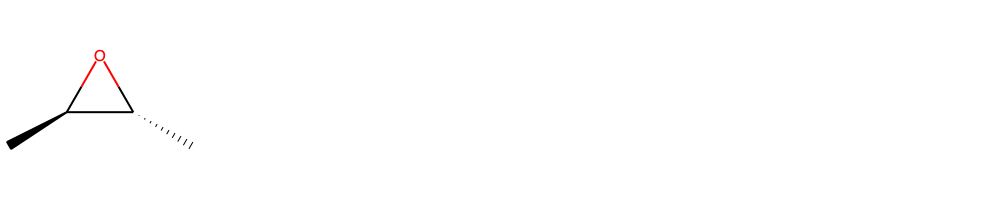

In [28]:
for name in ['eig', 'random']:
    print("%s, training: " % name, datasets[name]['train'].get_shape())
    mol_list = [Chem.MolFromSmiles(id_) for id_ in datasets[name]['train'].ids]
    
Chem.Draw.MolsToGridImage(mol_list[:10], molsPerRow=5)

## Keras Neural Networks

In [8]:
## Functions

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    ax[0].set_title(title)
    #plt.ylim([0,5])
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    ax[1].set_title(title)
    ax[1].legend()
    plt.show()

In [117]:
## Keras implementation 
from tensorflow import keras

# Initializer
# Initialise weights according to Hansen et al (2013)
initializer = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(100)))

# Network

model = tf.keras.Sequential([
keras.layers.Dense(400, input_shape=(23,), kernel_initializer=initializer, activation='sigmoid'),
keras.layers.Dense(100, activation='sigmoid'),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

# Optimizer
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Configure a model for mean-squared error regression.
model.compile(optimizer=sgd,
              loss='mae',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Save model weights checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint('sgd_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

# Train on Randomized dataset

# X_train = train_dataset.X
# y_train = train_dataset.y

X_train_eig = datasets['eig'][0].X
y_train_eig = datasets['eig'][0].y


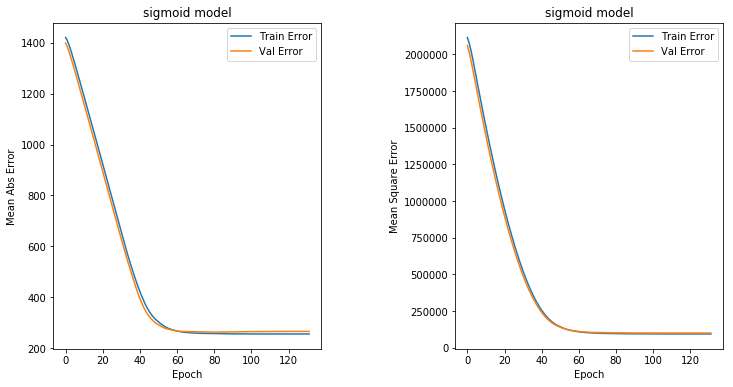

In [118]:
history = model.fit(X_train_eig, y_train_eig, validation_split = 0.1, epochs=500, 
                    callbacks=[early_stop], batch_size=25, verbose=0)

plot_history(history, "sigmoid model")

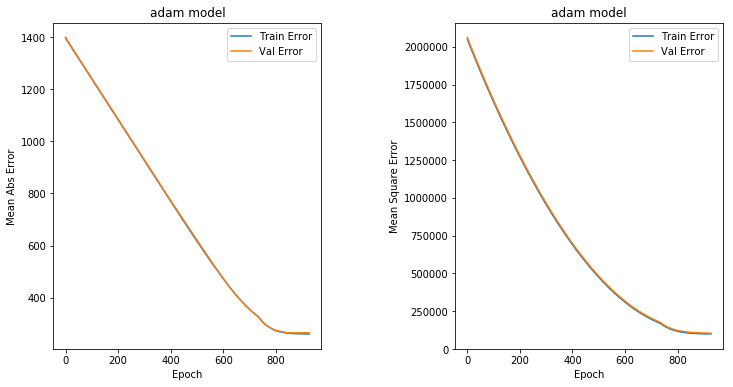

In [119]:
# Configure a model for mean-squared error regression.
model_adam = tf.keras.Sequential([
keras.layers.Dense(400, activation='sigmoid', input_shape=(23,), kernel_initializer=initializer),
keras.layers.Dense(100, activation='sigmoid'),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint('adam_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

model_adam.compile(optimizer='adam',
              loss='mae',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

history_adam = model_adam.fit(X_train, y_train, validation_split = 0.1, epochs=2000, 
                    callbacks=[early_stop, model_checkpoint], batch_size=25, verbose=0)

plot_history(history_adam, "adam model")

## DeepChem Models

In [11]:
from deepchem.molnet import load_qm7
from deepchem.models.tensorgraph.optimizers import ExponentialDecay
from sklearn.kernel_ridge import KernelRidge
tf.set_random_seed(123)

qm7_tasks, qm7_datasets, qm7_transformers = load_qm7(featurizer='CoulombMatrix', split='stratified', 
                                                      move_mean=True, reload=True)


qm7_train, qm7_valid, qm7_test = qm7_datasets

About to featurize qm7 dataset.
Loading raw samples now.
shard_size: 8192
Reading structures from /var/folders/lt/4hfpdkdn0mzf1tl30rhyncn0g8k1ts/T/gdb7.sdf.
Currently featurizing feature_type: CoulombMatrixEig
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 4.921 s
TIMING: dataset construction took 6.592 s
Loading dataset from disk.
TIMING: dataset construction took 0.049 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


In [15]:
qm7_datasets[0].X.shape

(5728, 23)

About to initialize singletask to multitask model
Initializing directory for task u0_atom
About to create task-specific datasets
Splitting multitask dataset into singletask datasets
TIMING: dataset construction took 0.007 s
Loading dataset from disk.
Processing shard 0
	Task u0_atom
Dataset for task u0_atom has shape ((5728, 23), (5728, 1), (5728, 1), (5728,))
Fitting model for task u0_atom
computed_metrics: [44.122791860729734]
Train scores [kcal/mol]
{'mean_absolute_error': 44.122791860729734}
computed_metrics: [56.22729403763118]
Validation scores [kcal/mol]
{'mean_absolute_error': 56.22729403763118}


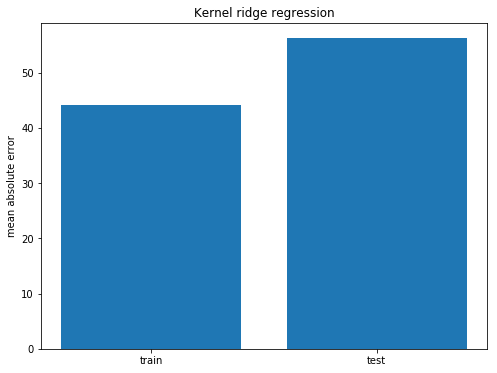

In [121]:
## Kernel ridge regression

def krr_model_builder(model_dir):
    sklearn_model = KernelRidge(kernel='laplacian', alpha=0.0001, gamma=0.0001)
    return dc.models.SklearnModel(sklearn_model, model_dir)

regression_metric = dc.metrics.Metric(
    dc.metrics.mean_absolute_error, mode="regression")

model = dc.models.SingletaskToMultitask(qm7_tasks, krr_model_builder)

# Fit trained model
model.fit(qm7_train)
#model.save()

train_evaluator = dc.utils.evaluate.Evaluator(model, qm7_train, qm7_transformers)
train_scores = train_evaluator.compute_model_performance([regression_metric])

print("Train scores [kcal/mol]")
print(train_scores)

test_evaluator = dc.utils.evaluate.Evaluator(model, qm7_test, qm7_transformers)
test_scores = test_evaluator.compute_model_performance([regression_metric])

print("Validation scores [kcal/mol]")
print(test_scores)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Kernel ridge regression")
plt.ylabel("mean absolute error")
plt.show()

In [ ]:
#Keras neural network



## DTNN

In [69]:
# Load QM7 dataset
tasks, datasets, transformers = dc.molnet.load_qm7_from_mat(move_mean=False)
train_dataset, valid_dataset, test_dataset = datasets

# Fit models
metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

# Batch size of models
batch_size = 50
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

model = dc.models.DTNNModel(
    len(tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")

# Fit trained model
model.fit(train_dataset, nb_epoch=50)

train_scores = model.evaluate(train_dataset, metric, transformers)
valid_scores = model.evaluate(valid_dataset, metric, transformers)

TIMING: dataset construction took 0.324 s
Loading dataset from disk.
TIMING: dataset construction took 0.285 s
Loading dataset from disk.
TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.115 s
Loading dataset from disk.
TIMING: dataset construction took 0.225 s
Loading dataset from disk.
TIMING: dataset construction took 0.031 s
Loading dataset from disk.
TIMING: dataset construction took 0.032 s
Loading dataset from disk.


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/nathalie.willems/anaconda3/envs/deepche

Ending global_step 999: Average loss 0.170004
Ending global_step 1999: Average loss 0.0085636
Ending global_step 2999: Average loss 0.00423588
Ending global_step 3999: Average loss 0.00336433
Ending global_step 4999: Average loss 0.00283679
Ending global_step 5750: Average loss 0.00189303
Instructions for updating:
Use standard file APIs to delete files with this prefix.
TIMING: model fitting took 224.006 s
computed_metrics: [10.155086]
computed_metrics: [0.998986262829149]
computed_metrics: [10.272173]
computed_metrics: [0.9988002801300446]


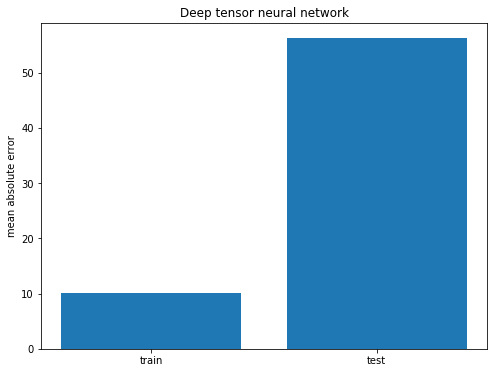

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Deep tensor neural network")
plt.ylabel("mean absolute error")
plt.show()

## Single task NN 

In [ ]:
from deepchem.molnet import load_qm7_from_mat
from deepchem.models.tensorgraph.optimizers import ExponentialDecay

print(tf.__version__)

qm7_tasks, datasets, transformers = load_qm7_from_mat(
    split='stratified', move_mean=True, reload=False)


qm_train, qm_valid, qm_test = datasets

fit_transformers = [dc.trans.CoulombFitTransformer(qm_train)]

rate = 0.001
dc_model = dc.models.MultitaskFitTransformRegressor(
    n_tasks=1,
    n_features=[23, 23],
    learning_rate=rate,
    momentum=.8,
    batch_size=25,
    weight_init_stddevs=[1 / np.sqrt(400), 1 / np.sqrt(100), 1 / np.sqrt(100)],
    bias_init_consts=[0., 0., 0.],
    layer_sizes=[400, 100, 100],
    dropouts=[0.01, 0.01, 0.01],
    fit_transformers=fit_transformers,
    n_evals=10,
    seed=123)




In [ ]:
# Fit trained model
dc_model.fit(qm_train, nb_epoch=50)

train_scores = dc_model.evaluate(qm_train, metric, transformers)
valid_scores = dc_model.evaluate(qm_valid, metric, transformers)